In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

データの読み込み

In [102]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv', header=None)

In [103]:
train['t'] = 1
test['t'] = 0
data = pd.concat([train,test], sort=True).reset_index(drop=True)

In [104]:
data.index = pd.to_datetime(data['datetime'])
data = data['2014-05-01':]
data = data.reset_index(drop=True)

In [105]:
data['days'] = data.index
data['precipitation'] = data['precipitation'].apply(lambda x: -1 if x=='--' else 0).astype(float)
data['fun'] = data['remarks'].apply(lambda x: 1 if x=='お楽しみメニュー' else 0)
data['curry'] = data['name'].apply(lambda x: 1 if x.find('curry')>=0 else 0)

In [106]:
use = ['t','datetime','weather', 'precipitation', 'fun', 'curry', 'days','y']

In [107]:
all_use = data[use]

In [108]:
all_use.head()

,t,datetime,weather,precipitation,fun,curry,days,y
0,1,2014-5-1,晴れ,-1.0,0,0,0,64.0
1,1,2014-5-2,晴れ,-1.0,0,0,1,47.0
2,1,2014-5-7,晴れ,-1.0,0,0,2,88.0
3,1,2014-5-8,薄曇,-1.0,0,0,3,59.0
4,1,2014-5-9,晴れ,-1.0,0,0,4,58.0


train と test に分割、不要カラムの削除、カテゴリ変数のダミー変数化

In [109]:
train = all_use[all_use['t']==1]
test = all_use[all_use['t']==0]
train = train.drop(columns=['t','datetime'])
test = test.drop(columns=['t','datetime','y'])
train =pd.get_dummies(train)
test = pd.get_dummies(test)

trainを学習用と検証用に分割

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=['y']), train['y'], test_size=0.4, random_state=42)

RandomForestClassifierでモデルの学習

In [111]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LinearRegression as LR

In [112]:
model = LR()
model.fit(X_train, y_train)

LinearRegression()

In [113]:
pre_train = model.predict(X_train)
pre_val = model.predict(X_val)

モデルの評価

In [114]:
from sklearn.metrics import mean_squared_error as MSE

In [115]:
train_rmse = MSE(y_train, pre_train)**0.5
val_rmse = MSE(y_val, pre_val)**0.5
print(train_rmse)
print(val_rmse)

10.062625584662163
13.042277418019356


可視化

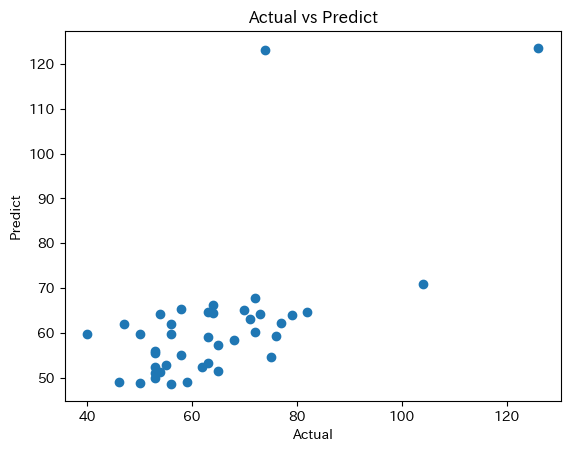

In [148]:
p = pd.DataFrame({'actual': y_val, 'predict': pre_val})
plt.scatter(p['actual'], p['predict'])
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.title('Actual vs Predict')
plt.show()


testを予測

In [117]:
test['weather_雷電'] = False

In [118]:
display(X_train.head(), test.head())

,precipitation,fun,curry,days,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨,weather_雷電
34,-1.0,0,0,34,False,False,False,True,False,False
7,-1.0,0,0,7,False,False,False,True,False,False
43,-1.0,0,0,43,False,False,False,True,False,False
73,-1.0,0,0,73,True,False,False,False,False,False
27,0.0,0,0,27,False,False,False,False,True,False


,precipitation,fun,curry,days,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨,weather_雷電
101,0.0,0,0,101,False,False,False,False,True,False
102,-1.0,0,0,102,False,False,True,False,False,False
103,-1.0,0,0,103,False,True,False,False,False,False
104,0.0,0,0,104,False,False,False,False,True,False
105,-1.0,0,0,105,False,True,False,False,False,False


In [119]:
pre_test = model.predict(test)

提出データの作成

In [120]:
pre_test[:5]

array([53.70610021, 47.29395776, 46.24962273, 53.12582346, 45.86277156])

In [121]:
sample.head(1)

,0,1
0,2014-10-1,24


In [122]:
submit = sample.copy()

In [125]:
submit[1] = pre_test

In [137]:
submit[1] = round(submit[1],0)
submit[1] = submit[1].astype(int)

In [138]:
submit.head()

,0,1
0,2014-10-1,54
1,2014-10-2,47
2,2014-10-3,46
3,2014-10-6,53
4,2014-10-7,46


In [139]:
submit.to_csv('submit.csv', index=False, header=None)

評価結果：11.66355269797593